# This is a library to find the best performing configuration from a set of dimensions (i.e. schemas, partition, storage) which can be specified inside the <b>settings.yaml</b> file in the resource

In [ ]:
%pip install PAPyA==0.1.0

In [ ]:
from PAPyA.file_reader import FileReader

config = "settings.yaml" # config file location
logs = "log" # logs file location

data = FileReader(config, logs, "100M", "schemas")
data.file_reader()

In [31]:
# this class takes single dimension and dataset sizes as parameters that user specified inside their log files
from Rank import SDRank

config = "settings.yaml" # config file location
logs = "log" # logs file location

schemaSDRank = SDRank(config, logs, '100M', 'schemas')
partitionSDRank = SDRank(config, logs, '100M', 'partition')
storageSDRank = SDRank(config, logs, '100M', 'storage')

In [32]:
# calculateRank method comes with parameters to sort the result and exclude queries that we want
excludeQuery = [1,2,5]
schemaSDRank.calculateRank('predicate', 'orc', excludeQuery).head()
schemaSDRank.plotRadar()

In [37]:
excludeQuery = [1,2,5]
partitionSDRank.calculateRank('predicate', excludeQuery).head()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
st.predicate.orc,7.0,1.0,0.0,0.0,0.958333
vt.predicate.avro,3.0,3.0,1.0,1.0,0.666667
extvt.predicate.avro,3.0,3.0,1.0,1.0,0.666667
st.predicate.avro,1.0,5.0,2.0,0.0,0.625000
vt.predicate.csv,4.0,1.0,1.0,2.0,0.625000


In [25]:
storageSDRank.calculateRank().head()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
st.predicate.orc,10.0,1.0,0.0,0.0,0.969697
st.subject.orc,10.0,1.0,0.0,0.0,0.969697
st.horizontal.orc,8.0,3.0,0.0,0.0,0.909091
vt.subject.parquet,5.0,5.0,1.0,0.0,0.787879
extvt.subject.parquet,6.0,3.0,1.0,1.0,0.757576


In [43]:
from Rank import SDRank
config = "settings_watdiv.yaml"
logs = "log_watdiv"

schemaSDRank = SDRank(config, logs, '100M', 'schemas')
storageSDRank = SDRank(config, logs, '100M', 'storage')
partitionSDRank = SDRank(config, logs, '100M', 'partition')

partitionSDRank.plotRadar()

In addition to radar plot, PAPyA also provides visualization that shows the performance of a single dimension parameters that user can choose in terms of their rank scores<br>
This <b>plot</b> method takes a single argument which is the view projection option that user can specify

<AxesSubplot:title={'center':'orc'}>

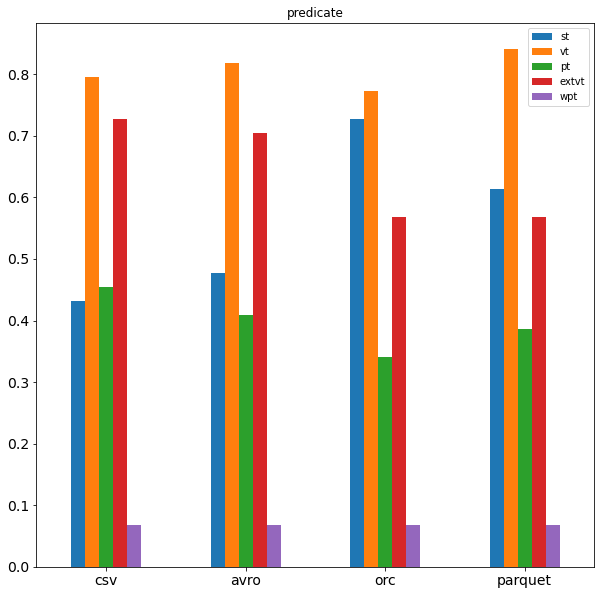

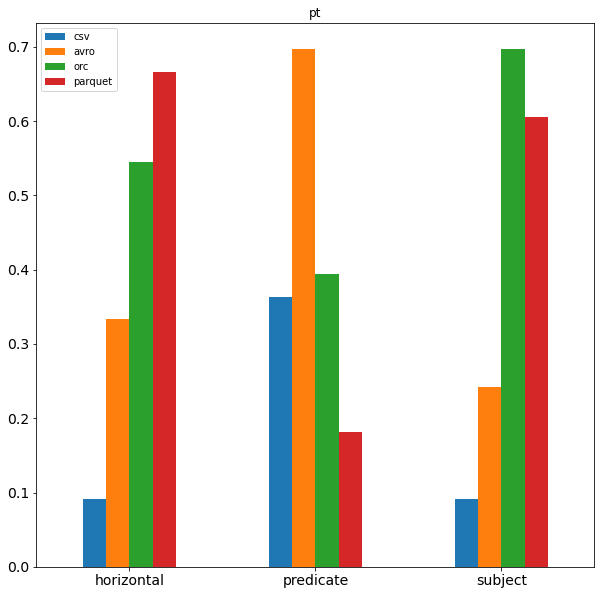

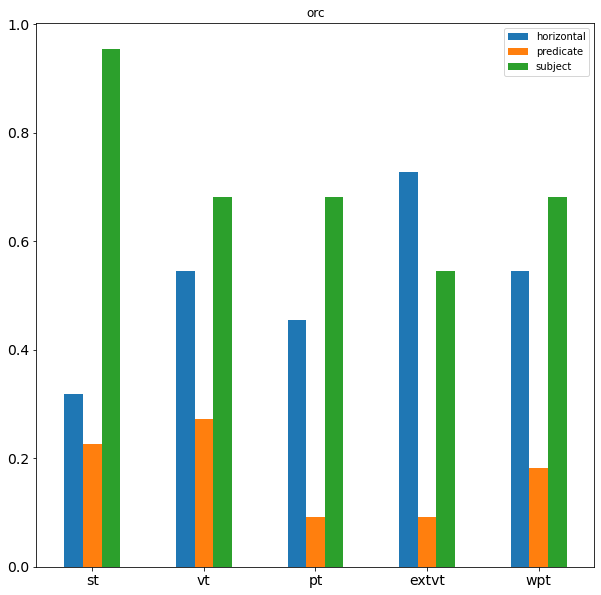

In [52]:
# example of schema dimension plots
config = "settings.yaml"
logs = "log"

SDRank(config, logs, '100M', 'schemas').plot('predicate')
SDRank(config, logs, '100M', 'storage').plot('pt')
SDRank(config, logs, '100M', 'partition').plot('orc')

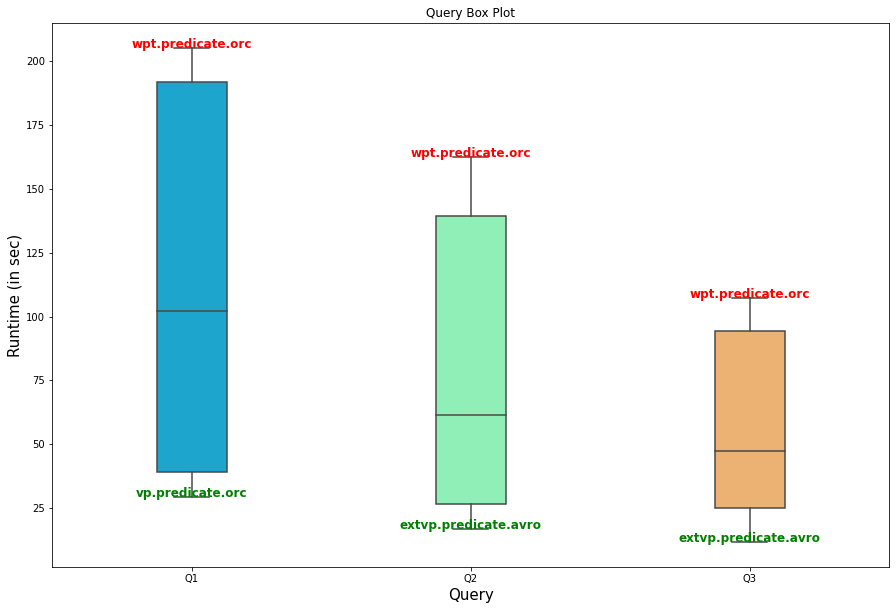

In [58]:
config = "settings_watdiv.yaml" # config file location
logs = "log_watdiv" # logs file location

from Rank import SDRank

query = ['Q1', 'Q2', 'Q3']
schemaSDRank = SDRank(config, logs, '100M', 'schemas').plotBox(query)

In [68]:
# example of MDRank class with 100M dataset size as ranking set of the experiment
from Rank import MDRank

config = "settings_watdiv.yaml"
logs = "log_watdiv"

multiDimensionRank = MDRank(config, logs, '100M')

In [65]:
# this is the top 5 configurations according to paretoQ method sorted from best to worst
multiDimensionRank.paretoQ().head()

,Solution,Dominated
0,extvp.predicate.csv,vp.horizontal.avro
1,extvp.predicate.orc,st.subject.orc
2,extvp.horizontal.csv,st.predicate.orc
3,pt.horizontal.parquet,vp.predicate.orc
4,extvp.subject.csv,st.predicate.parquet


In [66]:
# this is the top 5 configurations according to paretoAgg method sorted from best to worst
multiDimensionRank.paretoAgg().head()

,Solution,Dominated
0,pt.predicate.csv,wpt.predicate.orc
1,extvp.horizontal.csv,st.horizontal.csv
2,st.subject.orc,wpt.subject.csv
3,st.predicate.orc,pt.predicate.parquet
4,extvp.predicate.csv,pt.predicate.avro


The <b>plot</b> method shows the solutions for _paretoAgg_ as shades of green areas projected in a three dimensional space

(7, 3) (49, 3)


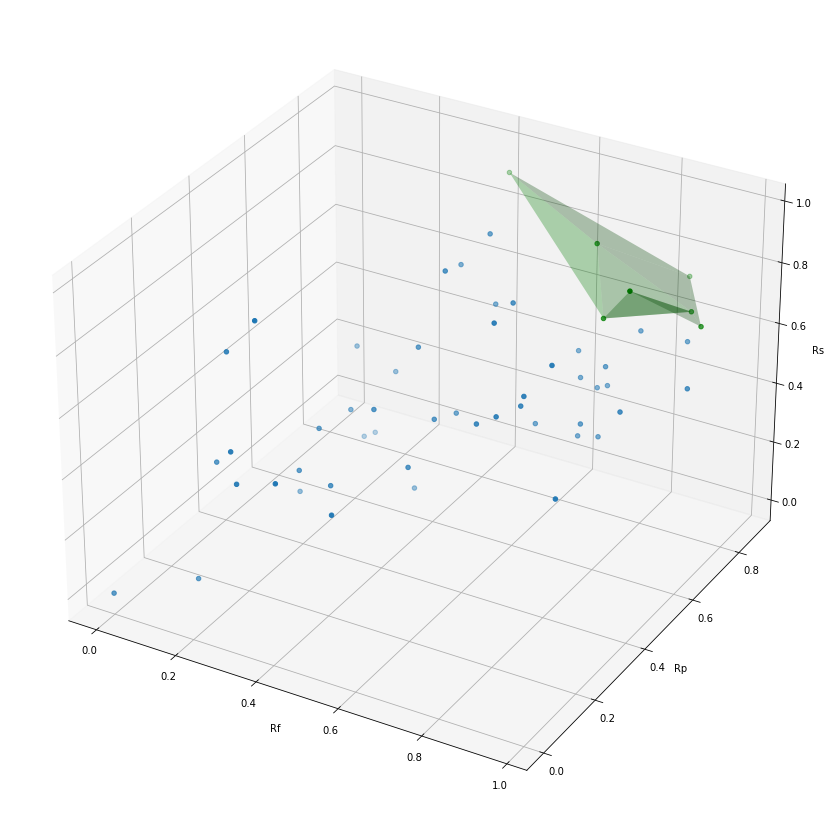

In [69]:
multiDimensionRank.plot()

In [72]:
# both conformance and coherence classes takes a list of ranking criterion that the user can specify
from Ranker import Conformance, Coherence

config = 'settings_watdiv.yaml'
logs = 'log_watdiv'

conformance_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']
coherence_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']

conf = Conformance(config, logs, '100M', conformance_set, 3, 8)
coh = Coherence(config, logs,coherence_set)

In [71]:
conf.run()

,100M
schemas,0.566667
partition,0.316667
storage,0.100000
paretoQ,0.616667
paretoAgg,0.266667


In [ ]:
conf.showCriteriaTable(dimension = 'paretoQ')

In [ ]:
conf.showTable(dimension = 'paretoQ')

In [74]:
coh.run('100M', '500M')

,Kendall's Index
schemas,0.396610
partition,0.467797
storage,0.431638
paretoQ,0.594958
paretoAgg,0.509091


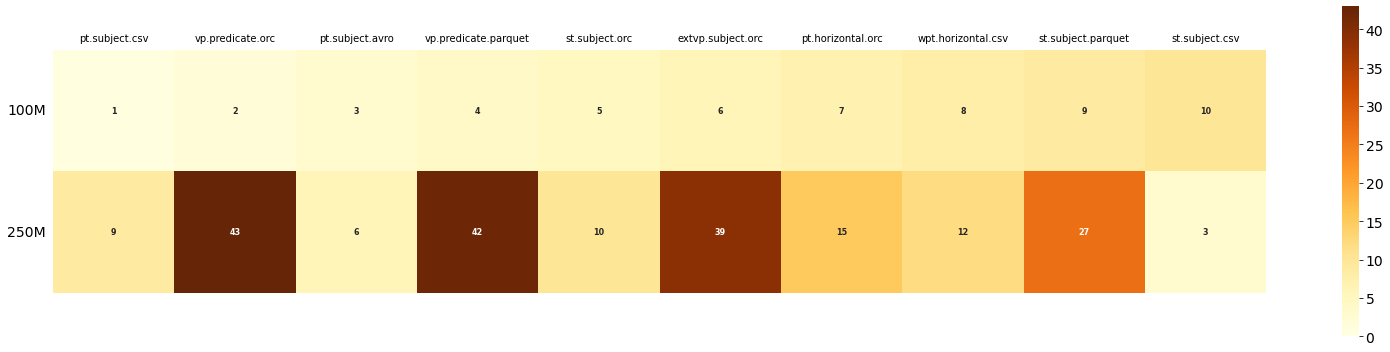

In [83]:
# only takes single dimensions
coh.heatMap('100M', "250M", dimension='partition')

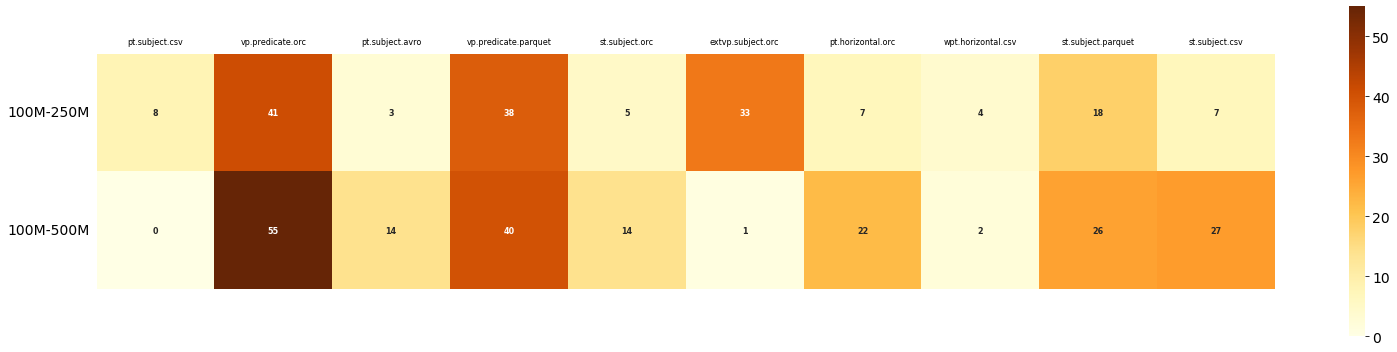

In [84]:
coh.heatMapSubtract('100M', '250M', "500M", dimension='partition')